In [2]:
import torch
import numpy as np
import datasets
import pickle
import pathlib
import os
from scipy import stats
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from datasets import load_dataset

configs = {
    "sst2": {
        "globenc_path": lambda epoch : f"/home/modaresi/globenc_extension/notebooks/outputs_globenc/sst2-e{epoch}_train.pickle",
        "logits_path": "/home/modaresi/globenc_extension/outputs/output_sst2_bert-base-uncased_0001_SEED0042/training_dynamics_after_step/",
        "hf_ds": "sst2",
    },
    "mnli": {
        "globenc_path": lambda epoch : f"/home/modaresi/globenc_extension/notebooks/outputs_globenc/mnli-e{epoch}_train.pickle",
        "logits_path": "/home/modaresi/globenc_extension/outputs/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "mnli",
    }
}

CONFIG = configs["mnli"]  # sst2/mnli

In [3]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    print(f"Read {path}")
    return data

In [4]:
globencs = list()  # [epoch, {globenc, tokens}, #]
for epoch in tqdm(range(6)):
    data = load_pickle(CONFIG["globenc_path"](epoch))
    globencs.append(data)

  0%|          | 0/6 [00:00<?, ?it/s]

Read /home/modaresi/globenc_extension/notebooks/outputs_globenc/mnli-e0_train.pickle
Read /home/modaresi/globenc_extension/notebooks/outputs_globenc/mnli-e1_train.pickle
Read /home/modaresi/globenc_extension/notebooks/outputs_globenc/mnli-e2_train.pickle
Read /home/modaresi/globenc_extension/notebooks/outputs_globenc/mnli-e3_train.pickle
Read /home/modaresi/globenc_extension/notebooks/outputs_globenc/mnli-e4_train.pickle
Read /home/modaresi/globenc_extension/notebooks/outputs_globenc/mnli-e5_train.pickle


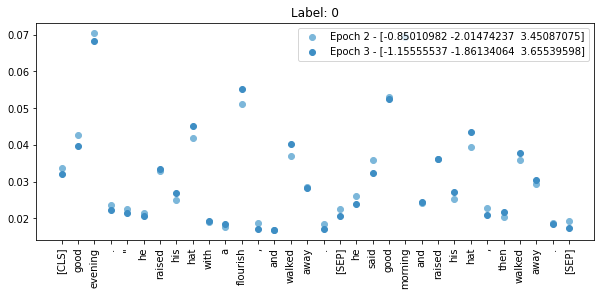

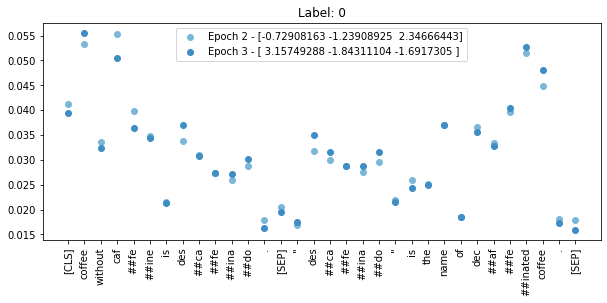

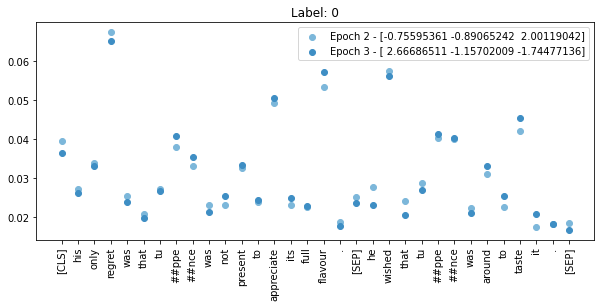

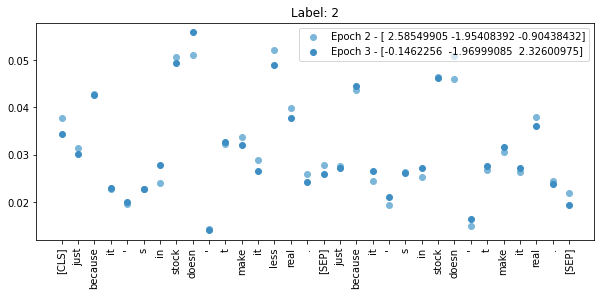

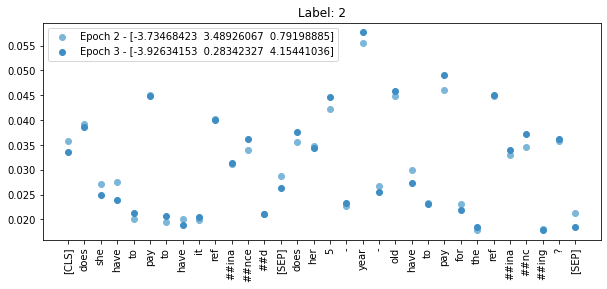

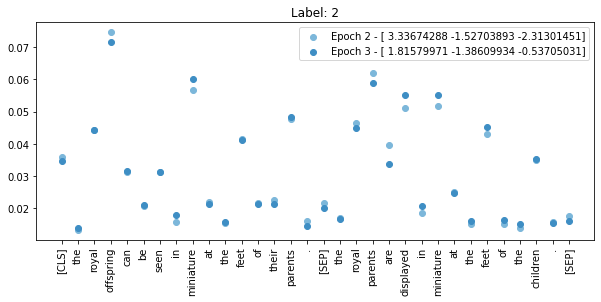

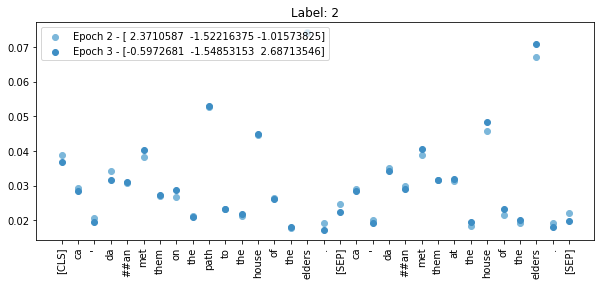

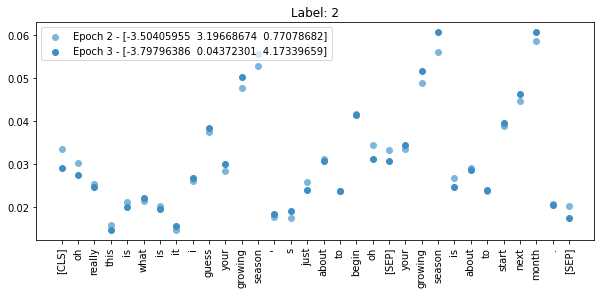

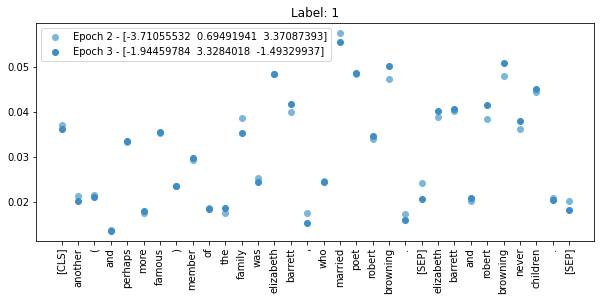

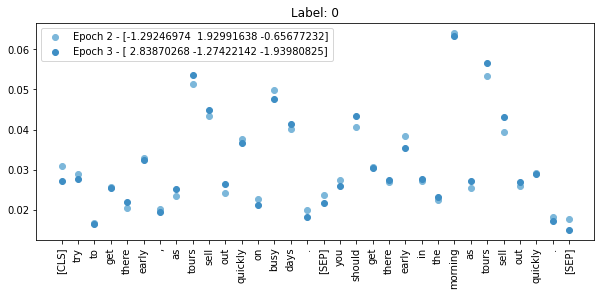

In [15]:
example_no = 176299
# example_no = 3
for example_no in [  5559,  89240, 136967, 176299, 209671, 248646, 253396, 277671, 282867, 353253]:
    plt.figure(figsize=(10, 4))
    x = np.arange(globencs[0]['globenc'][example_no].shape[0]) * 2
    colors = matplotlib.cm.Blues(np.linspace(0.1, 1, 6))
    # for i in range(0, 6):
    for i in [2,3]:
        plt.scatter(x, globencs[i]['globenc'][example_no][0] / globencs[i]['globenc'][example_no][0].sum(), label=f"Epoch {i} - {logits[i-1][example_no]}" if i > 0 else f"Epoch {i}", color=colors[i])
    plt.xticks(x, globencs[i]['tokens'][example_no], rotation=90)
    plt.title(f"Label: {ds['label'][example_no]}")
    plt.legend()
    plt.show()

In [48]:
example_no = 362144
# example_no = 3
idx_1, idx_2 = 4 ,5
order = np.argsort(globencs[idx_1]['globenc'][example_no][0])
ranks_1 = order.argsort()
order = np.argsort(globencs[idx_2]['globenc'][example_no][0])
ranks_2 = order.argsort()
print(np.sum(np.abs(ranks_2 - ranks_1) * globencs[idx_2]['globenc'][example_no][0] / globencs[idx_2]['globenc'][example_no][0].sum()), len(order))

0.32943861339128666 37


In [5]:
def load_logits(dir_path: str):
    file_list = os.listdir(dir_path)
    file_list.sort()
    print("Loading files in:", dir_path)
    idxs, logits = [], []
    for file_name in file_list:
        print(file_name)
        file_path = f"{dir_path}/{file_name}"
        if "idxs" in file_path:
            idxs.append(np.array(torch.load(file_path)))
        elif "logits" in file_path:
            logits.append(np.array(torch.load(file_path)))
        else:
            raise Exception("Wrong Files!")
    logits_ordered = np.zeros(np.array(logits).shape)
    for epoch in range(len(idxs)):
        logits_ordered[epoch][idxs[epoch]] = logits[epoch]
    return logits_ordered

def el2n(logits, labels):
    logits = torch.tensor(logits)  # (3, 392702, 3)
    labels = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=max(labels) + 1)  # (392702, 3)
    scores = []
    for epoch in range(len(logits)):
        errors = torch.nn.functional.softmax(logits[epoch], dim=-1) - labels
#         score = torch.linalg.vector_norm(errors, dim=-1, ord=2)
        score = np.linalg.norm(errors, ord=2, axis=-1)
        scores.append(score)
    return np.mean(np.array(scores), axis=0)

def cartography(logits, true_labels):
    probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
    corr_probs = np.sum(probs * np.expand_dims(torch.nn.functional.one_hot(true_labels, num_classes=max(true_labels) + 1).numpy(), axis=0), axis=-1)
    confs = np.mean(corr_probs, axis=0)
    variabilities = np.std(corr_probs, axis=0)
    return confs, variabilities

In [6]:
logits = load_logits(CONFIG["logits_path"])
logits.shape

Loading files in: /home/modaresi/globenc_extension/outputs/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch
epoch0_step012272_after_epoch_train_idxs_[392702].pt
epoch0_step012272_after_epoch_train_logits_[392702, 3].pt
epoch1_step024544_after_epoch_train_idxs_[392702].pt
epoch1_step024544_after_epoch_train_logits_[392702, 3].pt
epoch2_step036816_after_epoch_train_idxs_[392702].pt
epoch2_step036816_after_epoch_train_logits_[392702, 3].pt
epoch3_step049088_after_epoch_train_idxs_[392702].pt
epoch3_step049088_after_epoch_train_logits_[392702, 3].pt
epoch4_step061360_after_epoch_train_idxs_[392702].pt
epoch4_step061360_after_epoch_train_logits_[392702, 3].pt


(5, 392702, 3)

In [11]:
ds = load_dataset("glue", CONFIG["hf_ds"], split="train")
confs, vars = cartography(torch.tensor(logits), torch.tensor(ds['label']))

Reusing dataset glue (/opt/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [52]:
lengths = [len(globencs[0]['tokens'][i]) for i in range(len(ds))]

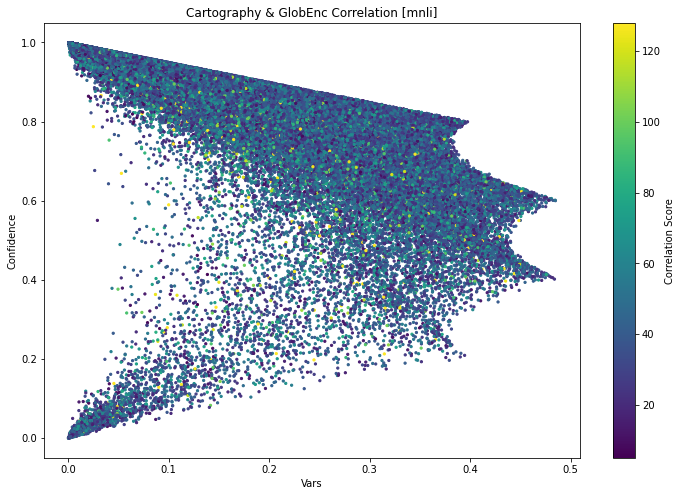

In [54]:
plt.figure(figsize=(12, 8))
plt.scatter(vars, confs, s=5, c=lengths)
plt.xlabel("Vars")
plt.ylabel("Confidence")
plt.title(f"Cartography & GlobEnc Correlation [{CONFIG['hf_ds']}]")
plt.colorbar(label="Correlation Score")

In [58]:
length = 32
np.intersect1d(np.argwhere(vars > 0.45).flatten(), np.argwhere(np.array(lengths) == length).flatten())

array([  5559,  89240, 136967, 176299, 209671, 248646, 253396, 277671,
       282867, 353253])

In [ ]:
plt.scatter()